# Implementation

The data used here is obtained by the Monte Carlo (MC) method with Metropolis algorithm that samples a 2D energy surface of the following form:

\begin{equation}
    U(x,y) =k_B T (0.28(0.25(a·x+b·y)^4+0.1(a·x+b·y)^3−3.24(a·x+b·y)^2+6.856(a·y−b·x)^2)+3.5) 
\end{equation}

where $a = 0.809$ and $b = 0.588$.

In [1]:
# %load energy_surface_simulation.py

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import scipy.constants as con
from IPython.display import HTML
from tqdm import tqdm
import time
import sys


def U(x, y, T=300, x_shift=0, y_shift=0, a=0.809, b=0.588):
    x = x - x_shift
    y = y - y_shift
    return con.R * T * (0.28 * (0.25 * (a*x + b*y)**4 + 0.1 * (a*x + b*y)**3 - 3.24*(a*x + b*y)**2 + 6.856*(a*y - b*x)**2)+3.5)


class energy_surface_simulation():

    def __init__(self, start_x=2, start_y=2, simulation_steps=1e5, T=300):
        self.T = T
        self.steps = int(simulation_steps)
        self.trajectory = np.zeros([2, self.steps+1])
        self.trajectory[:, 0] = [start_x, start_y]
        self.population_matrix = 0
        print("initial position:", self.trajectory[:,0])

    def MC_simulation(self, step_size=0.01):

        accepted_steps = 0
        E_old = U(self.trajectory[0,0], self.trajectory[1,0])

        for step in tqdm(range(self.steps)):

            # if accepted_steps == 1e6:
            #     print("Reached 1 000 000 accepted steps.")
            #     break

            self.trajectory[:, step+1] = np.copy(self.trajectory[:,step])
            # move particle
            phi = np.random.uniform(0, 2*np.pi)
            r_x = np.cos(phi)
            r_y = np.sin(phi)
            self.trajectory[0, step+1] += r_x
            self.trajectory[1, step+1] += r_y

            # calculate new energy
            E_new = U(self.trajectory[0, step+1], self.trajectory[1, step+1], T=self.T)

            if E_new < E_old:
                E_old = E_new
                accepted_steps +=1
                continue

            else: # check for metropolis criteria
                P = np.exp(- (E_new - E_old) / (con.R * self.T))
                q = np.random.uniform(0,1)
                if q < P:
                    E_old = E_new
                    accepted_steps += 1
                    continue
            
                else: # not accepted, move particle back
                    self.trajectory[0, step+1] -= r_x
                    self.trajectory[1, step+1] -= r_y

        print("Accepted steps:", accepted_steps)
        print("Acceptance: %.2f"%(accepted_steps/self.steps))

    def plot_population(self, trajectory=0, nbins=30, x_range=[-5,5], y_range=[-5,5], interpol='gaussian'):

        if type(trajectory)==int:
            trajectory = self.trajectory

        fig, ax = plt.subplots(figsize=(3,3), dpi=100)
        ax.set_title(r"Population")
        ax.set_xlabel(r"x")
        ax.set_ylabel(r"y")
        self.population_matrix, x, y = np.histogram2d(trajectory[0,:], trajectory[1,:], range=[x_range, y_range], bins=nbins)
        self.population_matrix = self.population_matrix.T

        im = ax.imshow(self.population_matrix, interpolation=interpol, origin="lower", 
                extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
        fig.colorbar(im, ax=ax)

## Simulation

- Set $T=300K$.
- Start at $(x,y) = (2,2)$.
- Set the MC step size to 0.01.
- Create 1,000,000 MC samples, i.e., carry out a calculation with 1,000,000
accepted moves.

In [2]:
sim = energy_surface_simulation(simulation_steps=300000, T=300)

initial position: [2. 2.]


In [3]:
sim.MC_simulation(step_size=0.1)

100%|██████████| 300000/300000 [00:06<00:00, 48210.20it/s]

Accepted steps: 109487
Acceptance: 0.36


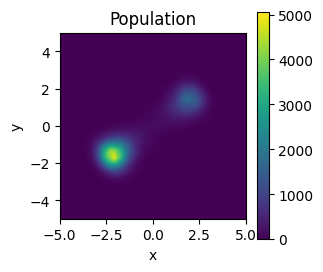

In [4]:
sim.plot_population(nbins=50)

## Sampling

Ploting the free energy ∆G(x,y) of the resulting sampling as ∆G(x,y) = - kBT ln P(x,y). The free energy can then be compared with a plot of the underlying U(x,y).

<ipython-input-5-d4c08d65f9a7>:2: RuntimeWarning: divide by zero encountered in log
  DeltaG = - con.R * sim.T * np.log(sim.population_matrix)


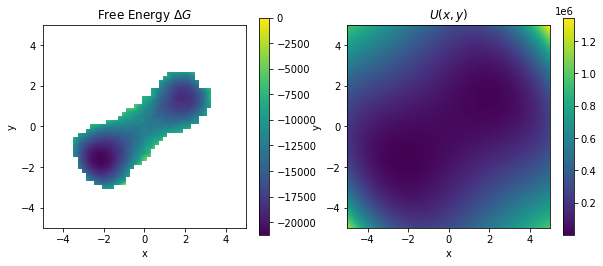

In [5]:
""" plotting the free energy landscape """
DeltaG = - con.R * sim.T * np.log(sim.population_matrix)

fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs.flatten()

axs[0].set_title(r"Free Energy $\Delta G$")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
im1 = axs[0].imshow(DeltaG, origin="lower", interpolation='gaussian', extent=[-5, 5, -5, 5])
fig.colorbar(im1, ax=axs[0])

""" plotting the energy landscape U(x,y) """
xy = np.meshgrid(np.linspace(-5, 5, 200) , np.linspace(-5, 5, 200))
x_array, y_array = xy[0].flatten(), xy[1].flatten()

data, a, b = np.histogram2d(x_array, y_array, weights=U(x_array, y_array), bins=100)
axs[1].set_title(r"$U(x,y)$")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
im2 = axs[1].imshow(data.T, origin="lower", extent=[-5, 5, -5, 5])
fig.colorbar(im2, ax=axs[1])

plt.show()

## Principal component analysis (PCA)

- Calculation of:
    - the means $\left<x\right>$ , $\left<y\right>$
    - the variances $var(x)= \left< \left( x− \left<x\right>\right)^2 \right>$ , $var(y)= \left< \left( y− \left<y\right>\right)^2 \right>$
    - covariances $cov(x, y) = cov(y, x) = \left<(x − \left<x\right> )(y − \left<y\right> )\right>$ from the simulated data.
- Create the covariance matrix $\sigma_{i,j}$
- Diagonalisation of $\sigma_{i,j}$ and save the eigenvectors $\vec{e}_{\lambda,k}$ and eigenvalues $\lambda_k$

In [6]:
x_mean = sim.trajectory[0,:].mean()
y_mean = sim.trajectory[1,:].mean()
x_var = sim.trajectory[0,:].var()
y_var = sim.trajectory[1,:].var()
xy_cov_matrix = np.cov(sim.trajectory)
print("mean of x and y:\n", x_mean, y_mean)
print()
print("variance of x and y:\n", x_var, y_var)
print()
print("covariance matrix: \n", xy_cov_matrix)

""" calculate the eigenvectors and eigenvalues """

eig_vals, eig_vecs = np.linalg.eig(xy_cov_matrix)

# print(eig_vals, eig_vecs)
# print(np.dot(xy_cov_matrix, eig_vecs[:,0]), eig_vecs[:,0] * eig_vals[0])

mean of x and y:
 -0.9348422547814091 -0.6800618071632926

variance of x and y:
 3.2181701056965397 1.830416344578308

covariance matrix: 
 [[3.21818083 2.15376979]
 [2.15376979 1.83042245]]


## Interpretation
Now we can determine the angle $\theta$ between the eigenvector $\vec{e}_{\lambda,1}$ (associated to the larger eigenvalue $\lambda,1$) and the x−axis. Afterwards, the data is rotated clockwise by this angle so that $\vec{e}_{\lambda,1}$ matches with the x−axis and $\vec{e}_{\lambda,2}$ with the y−axis.

The two points of higher population density are now parallel to the x-axis. This means, that the data now mostly flucutates along the (new) x-axis as there is only very littly fluctuation in y direction. Therefore, we managed to change our coordinate system in a way, that we now have one important variable (new x-direction) and one variable that has mostly the same value for all states (new y-direction).

0.6295632683321627
[[ 0.80828473  0.58879181]
 [-0.58879181  0.80828473]]
rotated start [2.79415308 0.43898584]
Rotated data:


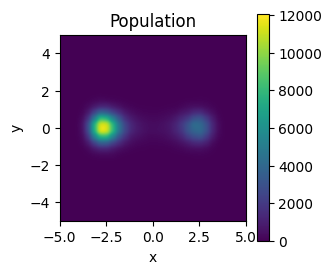

In [7]:
e_1 = eig_vecs[:,0]
e_2 = eig_vecs[:,1]

# since these eigenvectors are already normalised, the x-component of e_1 is cos(theta)
cos_theta = e_1[0]
theta = np.arccos(cos_theta)
print(theta)
# rotating CLOCKWISE -> use negative angle in rotation matrix
rotation_matrix = np.array([[np.cos(-theta), -np.sin(-theta)],
                            [np.sin(-theta),  np.cos(-theta)]])
# rotate data and plot it
print(rotation_matrix)
print("rotated start", np.dot(rotation_matrix, sim.trajectory[:,0]))
rotated_data = np.dot(rotation_matrix, sim.trajectory)
print("Rotated data:")
sim.plot_population(rotated_data)

## Calculation of the principal components $V_k = (x,y) · \vec{e}_{\lambda,k}$

The principal components are the projection of the data onto the eigenvectors or the correlation matrix. Calculating the variance of the principal components results in the corresponing eigenvalues $\lambda_k$:

In [10]:
""" calculating the principal components """
V_1 = np.dot(e_1, sim.trajectory)
V_2 = np.dot(e_2, sim.trajectory)
print("The variance of the principal components is:")
print(V_1.var(), V_2.var(), "\n")
print("The eigenvalues we calculated previously are:")
print(*eig_vals)

The variance of the principal components is:
4.787069953534504 0.261516496740342 

The eigenvalues we calculated previously are:
4.787085910434348 0.2615173684620069


The evolution of the two principal components is shown below for the first 10000 timesteps. One can see, that the component $V_1$ describes the movement between the two minima in the energy landscape while the component $V_2$ only shows the statistical fluctuations while being in either of the two minima.

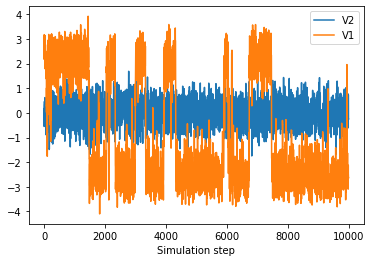

In [11]:
plt.plot(V_2[:10000], label="V2")
plt.plot(V_1[:10000], label="V1")
plt.xlabel("Simulation step")
plt.legend(loc=1)
plt.show()

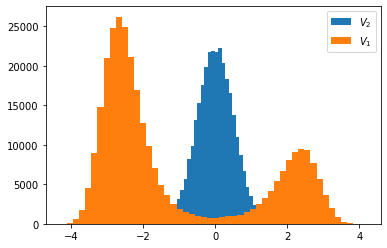

In [9]:
plt.hist(V_2, bins=50, label="$V_2$")
plt.hist(V_1, bins=50, label="$V_1$")
plt.legend()
plt.show()

## Summary

We had a look at the principle components analysis, which is useful to reduce the number of dimensions of the observed physics. In our simple example, we had a two dimensional energy landscape, that was used for a MC simulation. Analysing the data showed, that if using the standard cartesian coordinates, the variance of both coordinates is similar large and therefore both coordinates seem important for describing the data. However, after using PCA, one sees that the initial coordinate system is not the best choice for descibing the data. Because after rotating the data, the fluctuations in y-direction are very small compared to the fluctuations in x-direction and hence the data could be described using only the (new) x-coordinate. This reduced the dimensionality of the problem, which is very favourable for analysing data.